Our intent with this Kaggle kernel is to get to know if it is possible to predict the NBA Most Valued Player (MVP) of the year. 

In [55]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) #do not miss this line


import plotly as py
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

import os
print(os.listdir("../input"))

['nba-players-stats', 'mvp-voting']


In [56]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [57]:
%matplotlib inline

First, let's take a look at our data. Since this is a very large dataset, we should really clean and make it as objective as possible.

In [58]:
player_data = pd.read_csv('../input/nba-players-stats/player_data.csv')
Players = pd.read_csv('../input/nba-players-stats/Players.csv')
ss = pd.read_csv('../input/nba-players-stats/Seasons_Stats.csv')
mvp = pd.read_csv('../input/mvp-voting/mvp_table.csv')

In [59]:
player_data.columns

Index(['name', 'year_start', 'year_end', 'position', 'height', 'weight',
       'birth_date', 'college'],
      dtype='object')

In [60]:
Players.columns

Index(['Unnamed: 0', 'Player', 'height', 'weight', 'collage', 'born',
       'birth_city', 'birth_state'],
      dtype='object')

In [61]:
ss.columns

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

**Cross-Validation (Holdout):**
First, let's try Holdout approach.
From all available dataset, it looks like we can build up an analysis based on `Season_Stats.csv`

Also, we are going to use :
* 1985 to 2005 as training set
* 2006 to 2010 as validation set
* 2011 to 2017 as test set

In [62]:
ss.dropna(subset=['Year'], inplace=True)
ss.drop(['blanl','blank2'], axis=1, inplace=True) # empty columns

In [63]:
ss_train = ss[(ss['Year'].astype(int) > 1985) & (ss['Year'].astype(int) < 2006)]
ss_val = ss[(ss['Year'].astype(int) > 2005) & (ss['Year'].astype(int) < 2012)]
ss_test = ss[(ss['Year'].astype(int) > 2012)]


Starting the dirty work, we will clean up columns that might not be interesting, fill up (or maybe get rid off) unavailable information. For our Linear Regression, we will need only numerical data.

How many `NaN` or `infinite` numbers we have for each column ?

In [64]:
"""
a = []
for i in ss.columns:
    a.append(ss[i].isna().sum())
a = [x / ss.shape[0] for x in a] * 100
"""
a = ss.isna().sum()/len(ss)

In [65]:
data = [go.Bar(
    x=a.index,
    y=a
)]

py.offline.iplot(data, filename='percentage-of-nan')

As we can see from the above plot, fields like "3P" and "3P%" have too much blank values. This could be this way due to:
1. Many players are not use to shoot 3 point. Mainly Center player.

or

2. 3pt began in 1979. Let's plot the same chart after 1979 in the NBA.

Let's plot some charts to further validate our theory.

In [66]:
ss.Pos[ss['3P'].isna()].groupby(ss.Pos).value_counts()

Pos    Pos  
C      C         994
C-F    C-F        35
C-PF   C-PF        7
C-SF   C-SF        1
F      F         123
F-C    F-C        81
F-G    F-G        60
G      G         139
G-F    G-F        79
PF     PF       1021
PF-C   PF-C        4
PF-SF  PF-SF       3
PG     PG        895
SF     SF       1127
SF-PF  SF-PF       1
SF-PG  SF-PG       1
SF-SG  SF-SG       3
SG     SG       1120
SG-PG  SG-PG       2
SG-SF  SG-SF       1
Name: Pos, dtype: int64

In [67]:
ss_3pt = ss[(ss['Year'].astype(int) > 1979)]
a = ss_3pt.isna().sum()/len(ss_3pt)

data = [go.Bar(
    x=a.index,
    y=a
)]
py.offline.iplot(data)

We don't need data from the early basketball. Will focus 1985 till now.

In [68]:
ss = ss[ss['Year'] > 1985]

Looks like the data only confirms that thers is no much data from the older years. One more reason why we should leave it aside.

We should not forget to add our MVP column

In [69]:
# Create column mvp_votes and initialize with zeros
ss['mvp_votes'] = np.zeros(len(ss));

In [70]:
for i in mvp.index:
    try:
        a = ss[((ss['Player'] == str(mvp['Player'][i]))
                |(ss['Player'] == mvp['Player'][i]+'*') 
                & (ss['Year'] == mvp['Year'][i]))]
        if(a.index != None):
            ss['mvp_votes'][a.index] = mvp['mvp_score'][i]

    except:
        pass

Now that we have our dataset all done, we can check if the correlation matrix tell us something about relationship between variables.

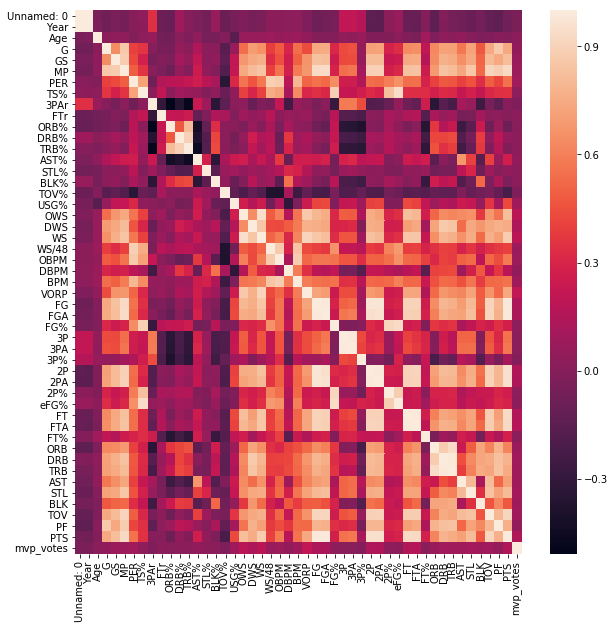

In [72]:
fig, ax = plt.subplots(figsize=(10,10))
corr = ss.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

The correlation matrix tell us that we first need to better select our variables. Other than that there is no much a human being is able to extract from it. 

This can be done programatically, e.g. "if correlation coefficient is below x, do not select this variable". Another way is to get rid variables that we already know won't give us useful information (at least we don't want them to give).

For this first attempt we will remove the 'team' column because to evaluate this information we would have to use encoding and, since there are more than 32 teams, this would generate a sparse matrix. Not sure yet on how to treat it. Same approach will take place with 'position'.

In [73]:
ss_fd = ss.drop(['Player','Year','BPM','VORP','Tm','Pos'], axis=1)

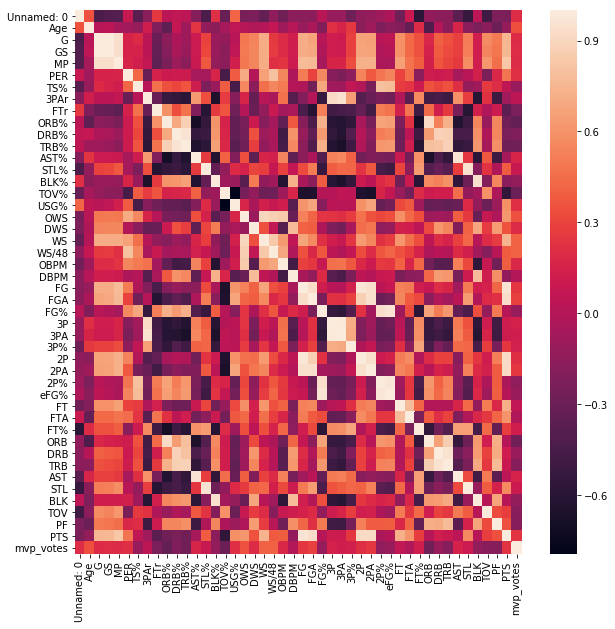

In [74]:
ss_ = ss_fd[ss_fd['mvp_votes'] != 0]
fig, ax = plt.subplots(figsize=(10,10))
corr = ss_.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax);

In [75]:
corr.mvp_votes

Unnamed: 0    0.204290
Age           0.340164
G             0.191102
GS            0.206510
MP            0.197957
PER           0.221645
TS%          -0.107899
3PAr          0.041296
FTr          -0.234350
ORB%         -0.324447
DRB%         -0.212240
TRB%         -0.272853
AST%          0.163654
STL%          0.085146
BLK%         -0.130447
TOV%         -0.300644
USG%          0.217560
OWS           0.343086
DWS           0.198599
WS            0.411550
WS/48         0.411379
OBPM          0.185945
DBPM         -0.003007
FG            0.247429
FGA           0.280790
FG%          -0.115789
3P            0.151514
3PA           0.130231
3P%           0.142219
2P            0.208773
2PA           0.244329
2P%          -0.142237
eFG%         -0.108069
FT            0.058526
FTA          -0.008932
FT%           0.129787
ORB          -0.273404
DRB          -0.110688
TRB          -0.184203
AST           0.155291
STL           0.098047
BLK          -0.133471
TOV          -0.177432
PF         

Drop variables with correlation lower than 0.15.

In [76]:
print("Correlation lower thas 0.1 : ")
print(ss_.columns[corr.mvp_votes < 0.1])
ss_.drop(ss_.columns[corr.mvp_votes < 0.1], axis=1, inplace=True)

Correlation lower thas 0.1 : 
Index(['TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'STL%', 'BLK%', 'TOV%',
       'DBPM', 'FG%', '2P%', 'eFG%', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'STL',
       'BLK', 'TOV', 'PF'],
      dtype='object')


**Decision Tree**
The first approach will be Decision Tree Regressor model. The targer will be "Based on this N stats, how many mvp votes would this player receive ?" At first, we will be using training data only from players that have received at least one vote.

Will divide our dataset into `train:75%` and `test:25%` set, randomly. There is no need to be stratified as we are not in a classification problem.

In [77]:
# Functions that will be in use from now on
def plot_tst_pred(pred, test):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(pred, color='darkblue', label='y pred')
    plt.plot(test.reset_index(drop=True), color='green', label='y_test')
    plt.ylabel('mvp votes')
    plt.xlabel('samples')
    plt.legend()
    plt.show()
    
def mean_error(pred, value):
    a = 0
    for i in range(len(pred)):
        a += abs(pred[i] - value[i])
    return a    

def correct_pred(pred, value):
    a = 0
    for i in range(len(pred)):
        if((pred[i] <= value[i] + 10) and (pred[i] >= value[i] - 10) and (pred[i] >= 1)): # will assume a range as right
            a += 1
    return a    

def fi(clf):
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    sorted_idx = sorted_idx[len(feature_importance) - 30:]
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(12,8))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

def check_nan(in_):
    print("Remaining NaN's:" + str(in_.isna().sum().sum()))
    if(in_.isna().sum().sum() > 0): 
        in_.fillna(0, inplace=True) # Avoid NaN in regression


def xy_sets(train, test):
    X_train = train.iloc[ : , 1:train.shape[1] - 1]
    y_train = train.iloc[:, train.shape[1] - 1]

    X_test = test.iloc[ : , 1:test.shape[1] - 1]
    y_test = test.iloc[ : , test.shape[1] - 1]
    return X_train, X_test, y_train, y_test

def results(pred, y):
    pos = 0
    f_pos = 0
    f_neg = 0
    for i in range(len(y)):
        if((pred[i] == 1 and y[i] == 1)): #or (pred[i] == 0 and y[i] == 0)):
            pos += 1
        elif(pred[i] == 1 and y[i] == 0):
            f_pos += 1
        elif(pred[i] == 0 and y[i] == 1):
            f_neg += 1
            
    return pos, f_pos, f_neg

In [78]:
check_nan(ss_)

Remaining NaN's:3


In [79]:
train, test = train_test_split(ss_, test_size=0.25, shuffle=True )

In [80]:
test.shape

(15, 24)

In [81]:
X_train, X_test, y_train, y_test = xy_sets(train, test)

In [82]:
clf = tree.DecisionTreeRegressor(max_depth=5)
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)

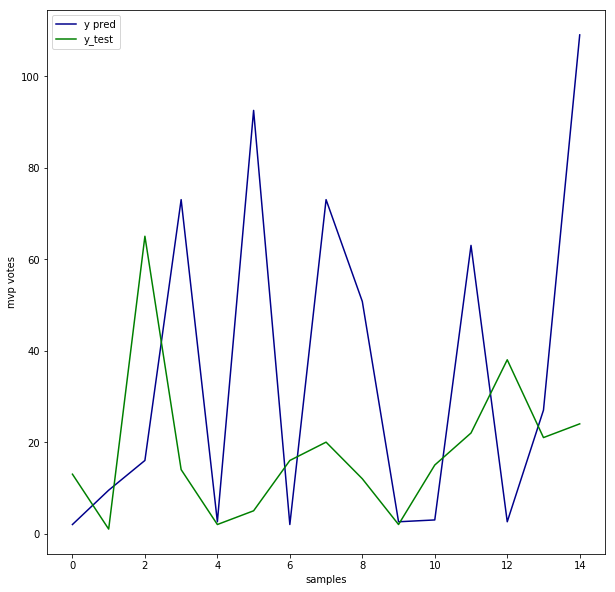

In [83]:
plot_tst_pred(pred,y_test)

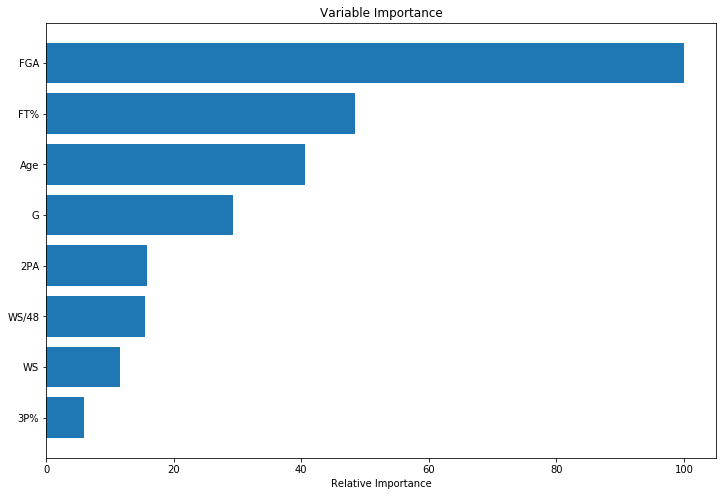

In [84]:
fi(clf)

From feature_importances_ for instance it looks like that 'PTS' does not make any influence in the Decision Tree. The interpretation behind thi is because `PTS` as itself does not tell anything about how many mvp points the player will receive. An idea to overcome this situation is maybe do some feature engineer and create variables which contain the information on "points made among other players" or "points above the average of that particular season".

On the other hand, `WS/48` implies lot of influence in the Decision Tree as it is a more complex variable which has a close meaning with MVP.


In [85]:
print(mean_error(y_test.reset_index(drop=True), pred))
print ("Correct prediction:" + str(correct_pred(pred,y_test.values)) + " Total :" + str(y_test.shape[0]))

501.35
Correct prediction:4 Total :15


**Random Forest** is just a Decision Tree Ensemble. Ensemble is a sofisticated method to aggregate an algorithm.

In [86]:
regr = RandomForestRegressor(max_depth=5, random_state=0,
                             n_estimators=100)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print(pred)
print(y_test)

[59.04090443 14.99974912 18.36681972 23.91931292 32.83611961 46.17844287
 47.6882771  33.11734384 18.90214618  4.65068586 18.19813898 41.05313664
 32.32810538 51.30630952 75.44585119]
11106    13.0
13743     1.0
8459     65.0
12089    14.0
9795      2.0
8273      5.0
8705     16.0
13689    20.0
10567    12.0
9882      2.0
15841    15.0
11195    22.0
9564     38.0
9747     21.0
11731    24.0
Name: mvp_votes, dtype: float64


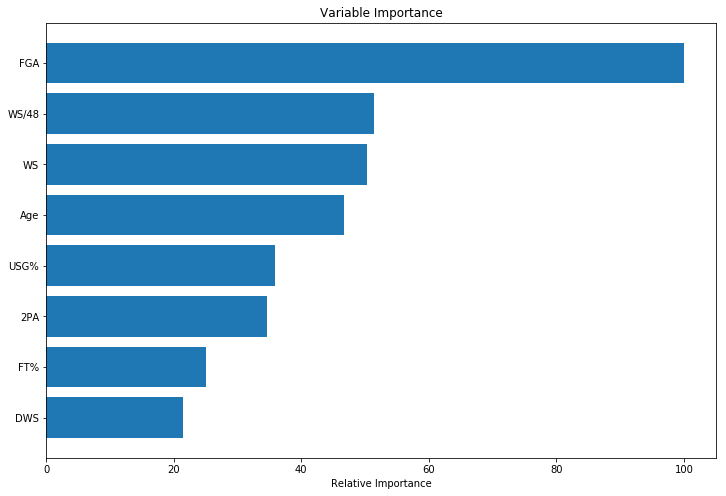

In [87]:
fi(regr)

A much intuitive variable importance is seen on the above

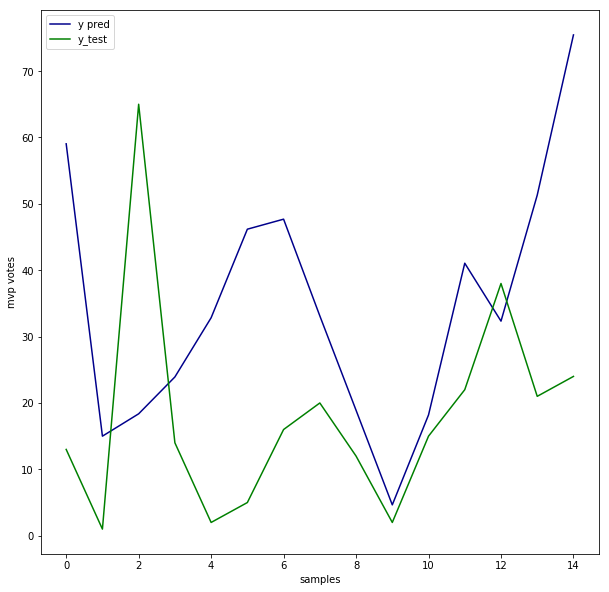

In [88]:
plot_tst_pred(pred, y_test)

Now let's apply our solution to the whole dataset. As now we have players that didn't even receive a vote, maybe there is a better possibility to extract feature importances.

In [89]:
ss_all = ss.drop(['Player','Year','BPM','VORP','Tm','Pos'], axis=1)
train, test = train_test_split(ss_all, test_size=0.2, shuffle=True )

In [90]:
check_nan(train)
check_nan(test)

Remaining NaN's:3460
Remaining NaN's:887


In [91]:
X_train, X_test, y_train, y_test = xy_sets(train,test)

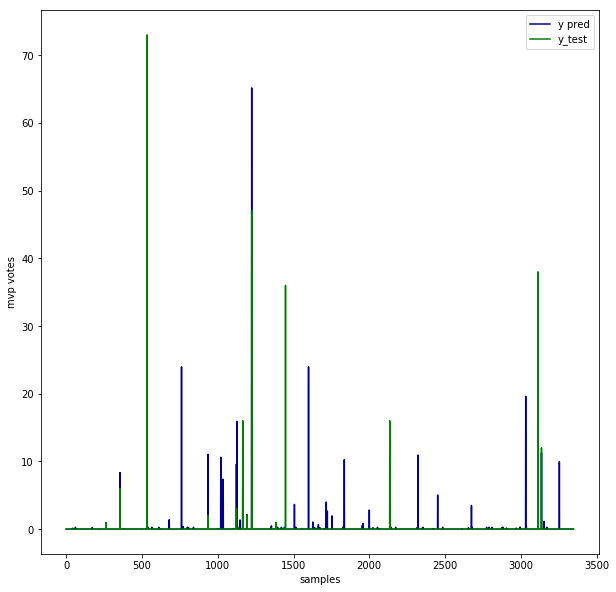

In [92]:
regr = RandomForestRegressor(max_depth=5, random_state=0,
                             n_estimators=100)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
plot_tst_pred(pred, y_test)

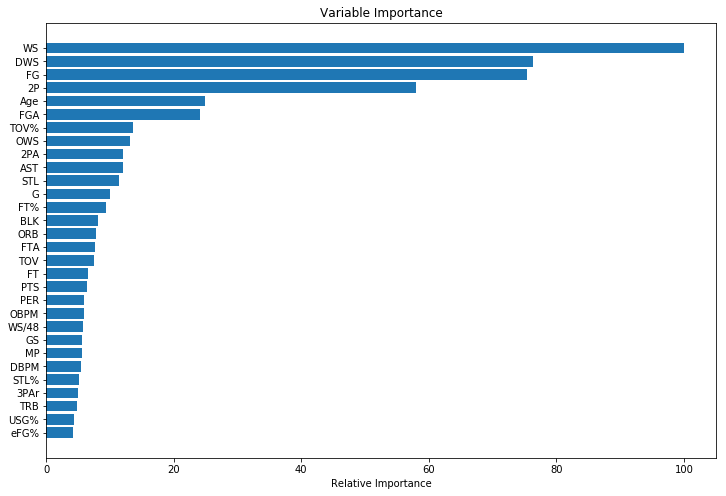

In [93]:
fi(regr)

**Linear Regression** The next approach is a simple Linear Regression in order to predict the mvp votes number.

In [94]:
X_train, X_test, y_train, y_test = xy_sets(train,test)
check_nan(train)
check_nan(test)

Remaining NaN's:0
Remaining NaN's:0


In [95]:
reg = linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                 normalize=False)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)

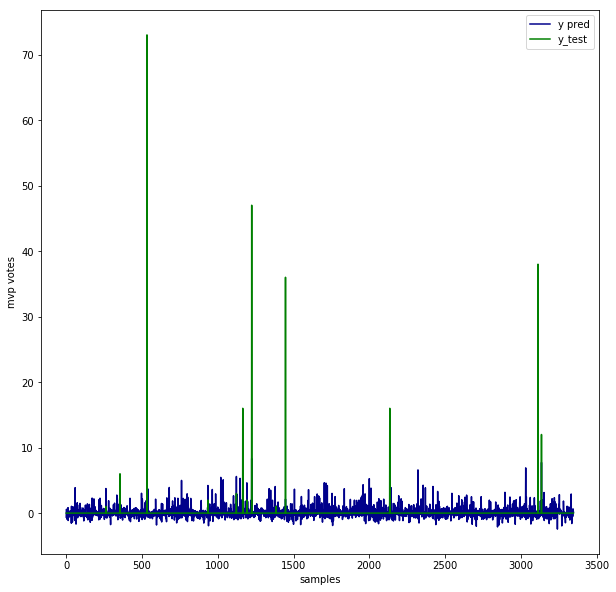

In [96]:
plot_tst_pred(pred, y_test)

What Linear Regression shows is just the expected. Since we have much higher number of players with score '0' in mvp votes, the 'weight' of this data in the regression pulls the linear hiperplane downwards, what can be observed in the chart above. It turns out that simple Linear Regression is not a very good approach here as the mvp candidates are performing a kind of 'outliar' play at this model perspective.

**Logistic Regression(Binary):** For Logistic Regression it is needed to transform the data into somethin binary - the player either is mvp or not.

In [97]:
# This cell is here only for debug purpose
ss_all = ss.drop(['Player','Year','BPM','VORP','Tm','Pos'], axis=1)

In [98]:
ss_all['mvp_votes'][ss_all['mvp_votes'] < 10] = 0 # This row should come before. This is important
ss_all['mvp_votes'][ss_all['mvp_votes'] >= 10] = 1 

In [99]:
ss_all['mvp_votes'].value_counts()

0.0    16704
1.0       34
Name: mvp_votes, dtype: int64

In [100]:
train, test = train_test_split(ss_all, test_size=0.25, shuffle=True )
check_nan(train)
check_nan(test)
X_train, X_test, y_train, y_test = xy_sets(train,test)

Remaining NaN's:3197
Remaining NaN's:1150


In [101]:
y_test.value_counts()

0.0    4175
1.0      10
Name: mvp_votes, dtype: int64

In [102]:
log_reg = linear_model.LogisticRegression(random_state=0, solver='sag',
                             multi_class='multinomial').fit(X_train, y_train)
pred = log_reg.predict(X_test)

In [103]:
pos, f_pos, f_neg = results(pred,y_test.values)
print("Positives:" + str(pos) + " False positives: " + str(f_pos) + " False negatives: " + str(f_neg) )

Positives:4 False positives: 3 False negatives: 6


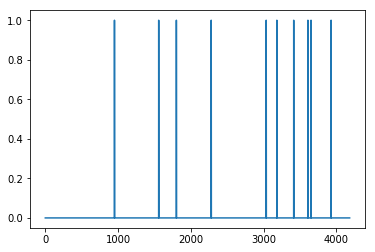

In [104]:
plt.plot(y_test.values);

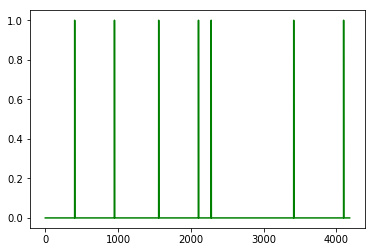

In [105]:
plt.plot(pred, color='green');

We are facing a circunstance where our machine learning algorithm should be forced to pick at least one player from each year to be chosen as the best player of the season. It turns out that, since our algorithm does not block on this constraint, it is free to pick unwanted and not allowed solutions, which are not possible in reality. Still need to figure out the model that has the best approach for this kind of problem. 

If you have any suggestion please comment below ! Appreciate!